Задача 4, часть 2

(+5 баллов) Также найти набор данных, с помощью которого можно получить гетерогенный граф. <br> Использовать несколько слоев RGATConv из библиотеки PyG для построения Relational GAT модели. <br>Разбить данные на тренировочные/валидационные/тестовые с помощью средств PyG, например RandomLinkSplit для задачи Link Prediction. <br>Обучить полученную модель, подобрать гиперпараметры (например, learning rate, multi-head attention) на валидационной выборке, и оценить качество предсказания на тестовой выборке

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import os
from sklearn.metrics import roc_auc_score

import torch
from torch import Tensor
import torch.nn.functional as F

In [ ]:
os.environ['TORCH'] = torch.__version__
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 77.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 39.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/nightly/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.9 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-d76bss65
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-d76bss65
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit bd5ae45c74a3fbb6b6ff818476f7651d84313d2a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.7.0-py3-none-any.whl

In [ ]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import SAGEConv, to_hetero

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
Загружаем данные с гугл-диска:
пользователи, фильмы, просмотры
"""

users_df = pd.read_csv('/content/drive/MyDrive/users.csv')
items_df = pd.read_csv('/content/drive/MyDrive/items.csv')
interactions_df = pd.read_csv('/content/drive/MyDrive/interactions.csv')

In [ ]:
"""
Таблица фильмов
"""

items_df

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15958,6443,series,Полярный круг,Arctic Circle,2018.0,"драмы, триллеры, криминал","Финляндия, Германия",NaN,16.0,NaN,Ханну Салонен,"Иина Куустонен, Максимилиан Брюкнер, Пихла Вии...","Во время погони за браконьерами по лесу, сотру...","убийство, вирус, расследование преступления, н..."
15959,2367,series,Надежда,NaN,2020.0,"драмы, боевики",Россия,0.0,18.0,NaN,Елена Хазанова,"Виктория Исакова, Александр Кузьмин, Алексей М...",Оригинальный киносериал от создателей «Бывших»...,"Надежда, 2020, Россия"
15960,10632,series,Сговор,Hassel,2017.0,"драмы, триллеры, криминал",Россия,0.0,18.0,NaN,"Эшреф Рейбрук, Амир Камдин, Эрик Эгер","Ола Рапас, Алиетт Офейм, Уильма Лиден, Шанти Р...",Криминальная драма по мотивам романов о шведск...,"Сговор, 2017, Россия"
15961,4538,series,Среди камней,Darklands,2019.0,"драмы, спорт, криминал",Россия,0.0,18.0,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родд...",Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия"


In [ ]:
"""
Данные по пользователям (кроме идентификатора) в модели не используются
"""

users_df

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
...,...,...,...,...,...
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0


In [ ]:
"""
Таблица просмотров пользователями фильмов
"""
interactions_df

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0


<Axes: >

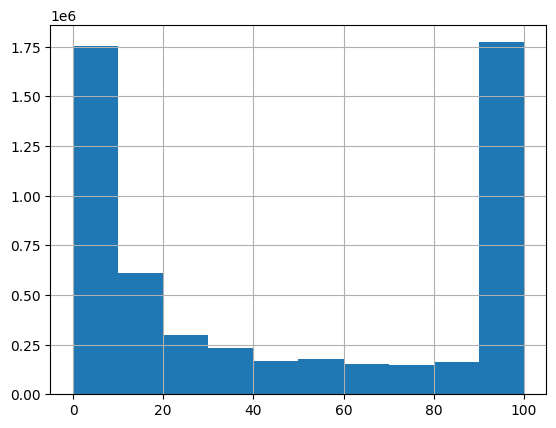

In [ ]:
"""
Видим, что в таблице более пяти миллионов записей - слишком много.
Надо сократить с помощью какой-либо фильтрации.
Например по доле просмотренного объёма фильма
"""

interactions_df.watched_pct.hist()

In [ ]:
"""
Количество уникальных пользователей в таблице просмотров
"""

len(interactions_df['item_id'].unique())

15706

In [ ]:
"""
Количество уникальных фильмов в таблице просмотров
"""

len(interactions_df['user_id'].unique())

962179

**Попробуем найти вариант фильтрации таблицы просмотров, который даст умеренное значение записей о просмотрах:**

In [ ]:
interactions_df.where((interactions_df.watched_pct == 100.0) & (interactions_df.total_dur > 40000)).dropna().shape

(95018, 5)

In [ ]:
interactions_df.where(interactions_df.watched_pct == 1.0).dropna().shape

(285565, 5)

In [ ]:
interactions_df.where(interactions_df.watched_pct == 10.0).dropna().shape

(106047, 5)

In [ ]:
interactions_df.where((interactions_df.watched_pct > 40.0) & (interactions_df.watched_pct < 50.0)).dropna().shape

(136504, 5)

In [ ]:
interactions_df.where((interactions_df.watched_pct > 40.0) & (interactions_df.watched_pct < 45.0)).dropna().shape

(66427, 5)

In [ ]:
interactions_df.where(interactions_df.watched_pct == 33.0).dropna().shape

(29219, 5)

**При фильтраиции с долей просмотренного гофильма в размере 33% возвращается 29219 записей таблицы**

**Будем работать с таким набором просмотров.**

In [ ]:
"""
Сохраним в переменную iter_df отфильтрованный набор записей
"""
iter_df = interactions_df[interactions_df["watched_pct"] == 33.0]
iter_df

,user_id,item_id,last_watch_dt,total_dur,watched_pct
331,942222,2657,2021-06-06,3161,33.0
800,400959,10283,2021-03-19,1899,33.0
913,331271,9070,2021-06-27,2210,33.0
927,188923,15034,2021-03-14,1605,33.0
949,486121,15428,2021-06-27,1908,33.0
...,...,...,...,...,...
5475298,477012,1465,2021-05-22,262,33.0
5475305,238516,14604,2021-06-30,1842,33.0
5475957,943112,2657,2021-07-27,2471,33.0
5476065,1029045,115,2021-08-21,1618,33.0


In [ ]:
"""
Создадим переменную, хранящую таблицу только с идетификаторами фильмов.
используется для фильтрации фильмов (через мердж)
"""
iter_df_for_filter = iter_df[['item_id']]
iter_df_for_filter

,item_id
331,2657
800,10283
913,9070
927,15034
949,15428
...,...
5475298,1465
5475305,14604
5475957,2657
5476065,115


In [ ]:
len(iter_df_for_filter['item_id'].unique())

3409

In [ ]:
iter_unique_item = iter_df_for_filter['item_id'].unique()
iter_unique_item

array([ 2657, 10283,  9070, ...,  8351, 13279,   115])

In [ ]:
iter_unique_item_df = pd.DataFrame({'item_id_unique': iter_unique_item})
iter_unique_item_df

,item_id_unique
0,2657
1,10283
2,9070
3,15034
4,15428
...,...
3404,6750
3405,5300
3406,8351
3407,13279


**Удаляем из фильмов фильмы, которые не вошли в фильтрованные итеры**

In [ ]:
"""
уберём лишние колонки таблицы, оставим идентификатор и набор жанров
"""

items_id_and_genres = items_df[['item_id', 'genres']]
items_id_and_genres

,item_id,genres
0,10711,"драмы, зарубежные, детективы, мелодрамы"
1,2508,"зарубежные, приключения, комедии"
2,10716,"криминал, зарубежные, триллеры, боевики, комедии"
3,7868,"драмы, зарубежные, мелодрамы"
4,16268,"драмы, спорт, советские, мелодрамы"
...,...,...
15958,6443,"драмы, триллеры, криминал"
15959,2367,"драмы, боевики"
15960,10632,"драмы, триллеры, криминал"
15961,4538,"драмы, спорт, криминал"


In [ ]:
"""
с помощью мержда, используя отфильтрованную таблицу просомтров,
оставим в таблице фильмов только нужные.
"""

clear_items_id_and_genres_3 = pd.merge(iter_unique_item_df, items_id_and_genres, left_on='item_id_unique', right_on='item_id', how='left')
clear_items_id_and_genres_3

,item_id_unique,item_id,genres
0,2657,2657,"драмы, триллеры"
1,10283,10283,"драмы, ужасы, фэнтези"
2,9070,9070,"драмы, комедии"
3,15034,15034,"драмы, фантастика, триллеры"
4,15428,15428,"историческое, драмы, военные, мелодрамы, боевики"
...,...,...,...
3404,6750,6750,"драмы, зарубежные, комедии"
3405,5300,5300,"драмы, зарубежные, боевики, криминал"
3406,8351,8351,"боевики, аниме, приключения"
3407,13279,13279,документальное


In [ ]:
"""
отбросим ненужный столбец, добавившийся при мердже
"""
clear_items_id_and_genres = clear_items_id_and_genres_3[['item_id', 'genres']]
clear_items_id_and_genres

,item_id,genres
0,2657,"драмы, триллеры"
1,10283,"драмы, ужасы, фэнтези"
2,9070,"драмы, комедии"
3,15034,"драмы, фантастика, триллеры"
4,15428,"историческое, драмы, военные, мелодрамы, боевики"
...,...,...
3404,6750,"драмы, зарубежные, комедии"
3405,5300,"драмы, зарубежные, боевики, криминал"
3406,8351,"боевики, аниме, приключения"
3407,13279,документальное


In [ ]:
"""
установим колонку id в качестве индекса
"""

clear_items_id_and_genres = clear_items_id_and_genres.set_index('item_id')
clear_items_id_and_genres

,genres
item_id,
2657,"драмы, триллеры"
10283,"драмы, ужасы, фэнтези"
9070,"драмы, комедии"
15034,"драмы, фантастика, триллеры"
15428,"историческое, драмы, военные, мелодрамы, боевики"
...,...
6750,"драмы, зарубежные, комедии"
5300,"драмы, зарубежные, боевики, криминал"
8351,"боевики, аниме, приключения"


In [ ]:
"""
Сделаем гетдумисы по жанрам фильмов
"""
genres = clear_items_id_and_genres['genres'].str.get_dummies(',')
genres

,аниме,биография,боевики,вестерн,военные,вокруг света,детективы,детские песни,для детей,документальное,...,ток-шоу,триллеры,ужасы,фантастика,фильмы,фильмы hbo,фитнес,футбол,фэнтези,юмор
item_id,,,,,,,,,,,,,,,,,,,,,
2657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10283,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15034,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15428,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5300,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8351,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
"""
сохраним эту таблицу в виде торч-тензора
"""

movie_feat = torch.from_numpy(genres.values).to(torch.float)

**Удаление лишних столбцов в таблице просмотров**

In [ ]:
iter_df

,user_id,item_id,last_watch_dt,total_dur,watched_pct
331,942222,2657,2021-06-06,3161,33.0
800,400959,10283,2021-03-19,1899,33.0
913,331271,9070,2021-06-27,2210,33.0
927,188923,15034,2021-03-14,1605,33.0
949,486121,15428,2021-06-27,1908,33.0
...,...,...,...,...,...
5475298,477012,1465,2021-05-22,262,33.0
5475305,238516,14604,2021-06-30,1842,33.0
5475957,943112,2657,2021-07-27,2471,33.0
5476065,1029045,115,2021-08-21,1618,33.0


In [ ]:
iter_df = iter_df[['user_id', 'item_id']]
iter_df

,user_id,item_id
331,942222,2657
800,400959,10283
913,331271,9070
927,188923,15034
949,486121,15428
...,...,...
5475298,477012,1465
5475305,238516,14604
5475957,943112,2657
5476065,1029045,115


In [ ]:
print(len(iter_df['user_id'].unique()))
print(len(iter_df['item_id'].unique()))

27598
3409


#Подготовка данных для передачи в модель

In [ ]:
"""
Создадим датафрейм, хранящий уникальные идентификаторы пользователей и их порядковые номера.
"""

# Create a mapping from unique user indices to range [0, num_user_nodes):
unique_user_id = iter_df['user_id'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
print("Mapping of user IDs to consecutive values:")
print("==========================================")
#print(unique_user_id.head())
unique_user_id

Mapping of user IDs to consecutive values:


,userId,mappedID
0,942222,0
1,400959,1
2,331271,2
3,188923,3
4,486121,4
...,...,...
27593,477012,27593
27594,238516,27594
27595,943112,27595
27596,1029045,27596


In [ ]:
"""
Создадим датафрейм, хранящий уникальные идентификаторы фильмов и их порядковые номера.
"""

# Create a mapping from unique movie indices to range [0, num_movie_nodes):
unique_movie_id = iter_df['item_id'].unique()
unique_movie_id = pd.DataFrame(data={
    'movieId': clear_items_id_and_genres.index,
    'mappedID': pd.RangeIndex(len(clear_items_id_and_genres)),
})
print("Mapping of movie IDs to consecutive values:")
print("===========================================")
#print(unique_movie_id.head())
unique_movie_id

Mapping of movie IDs to consecutive values:


,movieId,mappedID
0,2657,0
1,10283,1
2,9070,2
3,15034,3
4,15428,4
...,...,...
3404,6750,3404
3405,5300,3405
3406,8351,3406
3407,13279,3407


In [ ]:
"""
Мёрджим таблицу просмотров и уникальных пользователей, чтобы понять какой
пользователь какой фильм смотрел (с учётом изначальной фильтрации
про 33% просмотра длины фильма)
"""

ratings_user_id = pd.merge(iter_df['user_id'], unique_user_id,
                            left_on='user_id', right_on='userId', how='left')
ratings_user_id

,user_id,userId,mappedID
0,942222,942222,0
1,400959,400959,1
2,331271,331271,2
3,188923,188923,3
4,486121,486121,4
...,...,...,...
29214,477012,477012,27593
29215,238516,238516,27594
29216,943112,943112,27595
29217,1029045,1029045,27596


In [ ]:
"""
Аналогично для фильмов, смёрдживая таблицу уникальных идентификаторов фильмов.
"""

ratings_movie_id = pd.merge(iter_df['item_id'], unique_movie_id,
                            left_on='item_id', right_on='movieId', how='left')
ratings_movie_id

,item_id,movieId,mappedID
0,2657,2657,0
1,10283,10283,1
2,9070,9070,2
3,15034,15034,3
4,15428,15428,4
...,...,...,...
29214,1465,1465,8
29215,14604,14604,682
29216,2657,2657,0
29217,115,115,3408


In [ ]:
"""
приводим полученные таблицы к типу торч
"""
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)

ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)


In [ ]:
"""
объединяем в пары два вышеполученные тороч-вектора
"""
edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)

In [ ]:
edge_index_user_to_movie

tensor([[    0,     1,     2,  ..., 27595, 27596, 27597],
        [    0,     1,     2,  ...,     0,  3408,     0]])

###Продолжаем подготовку данных

In [ ]:
"""
Инициализируем и наполняем данными объект класса HeteroData().
Сохраняем в узлах идентификаторы пользователей и фильмов.
В вершины добавляются признаки.
Также создаются обратны рёбра
"""

data = HeteroData()

# Save node indices:
data["user"].node_id = torch.arange(len(unique_user_id))
data["movie"].node_id = torch.arange(len(clear_items_id_and_genres))

# Add the node features and edge indices:
data["movie"].x = movie_feat
data["user", "rates", "movie"].edge_index = edge_index_user_to_movie

# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)

print(data)

HeteroData(
  user={ node_id=[27598] },
  movie={
    node_id=[3409],
    x=[3409, 105],
  },
  (user, rates, movie)={ edge_index=[2, 29219] },
  (movie, rev_rates, user)={ edge_index=[2, 29219] }
)


In [ ]:
"""
для разделения данных в библиотеке есть специальный класс
"""

transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=("user", "rates", "movie"),
    rev_edge_types=("movie", "rev_rates", "user"),
)

In [ ]:
train_data, val_data, test_data = transform(data)

In [ ]:
train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)

Training data:
HeteroData(
  user={ node_id=[27598] },
  movie={
    node_id=[3409],
    x=[3409, 105],
  },
  (user, rates, movie)={
    edge_index=[2, 16364],
    edge_label=[7013],
    edge_label_index=[2, 7013],
  },
  (movie, rev_rates, user)={ edge_index=[2, 16364] }
)

Validation data:
HeteroData(
  user={ node_id=[27598] },
  movie={
    node_id=[3409],
    x=[3409, 105],
  },
  (user, rates, movie)={
    edge_index=[2, 23377],
    edge_label=[8763],
    edge_label_index=[2, 8763],
  },
  (movie, rev_rates, user)={ edge_index=[2, 23377] }
)


In [ ]:
"""
Подготовка мини-батчей (если они нужны)
"""

edge_label_index = train_data["user", "rates", "movie"].edge_label_index
edge_label = train_data["user", "rates", "movie"].edge_label

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)


Sampled mini-batch:
HeteroData(
  user={
    node_id=[2405],
    n_id=[2405],
    num_sampled_nodes=[3],
  },
  movie={
    node_id=[499],
    x=[499, 105],
    n_id=[499],
    num_sampled_nodes=[3],
  },
  (user, rates, movie)={
    edge_index=[2, 2137],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[2137],
    num_sampled_edges=[2],
    input_id=[128],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 1822],
    e_id=[1822],
    num_sampled_edges=[2],
  }
)


In [ ]:
"""
Создаём классы сетей.
Инициализируем модель
"""


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:


        #self.movie_lin = torch.nn.Linear(20, hidden_channels)

        self.movie_lin = torch.nn.Linear(105, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)

        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)

        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())

        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
        }

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            data["user", "rates", "movie"].edge_label_index,
        )

        return pred


model = Model(hidden_channels=64)

print(model)

Model(
  (movie_lin): Linear(in_features=105, out_features=64, bias=True)
  (user_emb): Embedding(27598, 64)
  (movie_emb): Embedding(3409, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__rates__movie): SAGEConv(64, 64, aggr=mean)
      (movie__rev_rates__user): SAGEConv(64, 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__rates__movie): SAGEConv(64, 64, aggr=mean)
      (movie__rev_rates__user): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Classifier()
)


In [ ]:
"""
Запуск обучения
"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_arr = []
for epoch in range(1, 30):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data.to(device)
        pred = model(sampled_data)

        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    loss_arr.append(total_loss / total_examples)
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cpu'


100%|██████████| 55/55 [00:03<00:00, 17.19it/s]


Epoch: 001, Loss: 0.4700


100%|██████████| 55/55 [00:01<00:00, 28.63it/s]


Epoch: 002, Loss: 0.3814


100%|██████████| 55/55 [00:01<00:00, 29.68it/s]


Epoch: 003, Loss: 0.3311


100%|██████████| 55/55 [00:01<00:00, 29.82it/s]


Epoch: 004, Loss: 0.2955


100%|██████████| 55/55 [00:01<00:00, 30.09it/s]


Epoch: 005, Loss: 0.2790


100%|██████████| 55/55 [00:01<00:00, 29.88it/s]


Epoch: 006, Loss: 0.2569


100%|██████████| 55/55 [00:02<00:00, 22.84it/s]


Epoch: 007, Loss: 0.2371


100%|██████████| 55/55 [00:02<00:00, 21.78it/s]


Epoch: 008, Loss: 0.2210


100%|██████████| 55/55 [00:01<00:00, 27.85it/s]


Epoch: 009, Loss: 0.2017


100%|██████████| 55/55 [00:01<00:00, 30.70it/s]


Epoch: 010, Loss: 0.1916


100%|██████████| 55/55 [00:01<00:00, 30.21it/s]


Epoch: 011, Loss: 0.1717


100%|██████████| 55/55 [00:01<00:00, 30.10it/s]


Epoch: 012, Loss: 0.1627


100%|██████████| 55/55 [00:01<00:00, 30.73it/s]


Epoch: 013, Loss: 0.1446


100%|██████████| 55/55 [00:02<00:00, 27.49it/s]


Epoch: 014, Loss: 0.1377


100%|██████████| 55/55 [00:02<00:00, 23.23it/s]


Epoch: 015, Loss: 0.1268


100%|██████████| 55/55 [00:02<00:00, 22.35it/s]


Epoch: 016, Loss: 0.1161


100%|██████████| 55/55 [00:01<00:00, 30.46it/s]


Epoch: 017, Loss: 0.1105


100%|██████████| 55/55 [00:01<00:00, 30.00it/s]


Epoch: 018, Loss: 0.1030


100%|██████████| 55/55 [00:01<00:00, 30.43it/s]


Epoch: 019, Loss: 0.0998


100%|██████████| 55/55 [00:01<00:00, 30.11it/s]


Epoch: 020, Loss: 0.0887


100%|██████████| 55/55 [00:01<00:00, 30.55it/s]


Epoch: 021, Loss: 0.0850


100%|██████████| 55/55 [00:04<00:00, 12.45it/s]


Epoch: 022, Loss: 0.0855


100%|██████████| 55/55 [00:02<00:00, 23.35it/s]


Epoch: 023, Loss: 0.0757


100%|██████████| 55/55 [00:02<00:00, 23.07it/s]


Epoch: 024, Loss: 0.0698


100%|██████████| 55/55 [00:02<00:00, 25.36it/s]


Epoch: 025, Loss: 0.0698


100%|██████████| 55/55 [00:01<00:00, 30.17it/s]


Epoch: 026, Loss: 0.0603


100%|██████████| 55/55 [00:01<00:00, 30.02it/s]


Epoch: 027, Loss: 0.0673


100%|██████████| 55/55 [00:02<00:00, 27.49it/s]


Epoch: 028, Loss: 0.0584


100%|██████████| 55/55 [00:02<00:00, 23.15it/s]

Epoch: 029, Loss: 0.0597


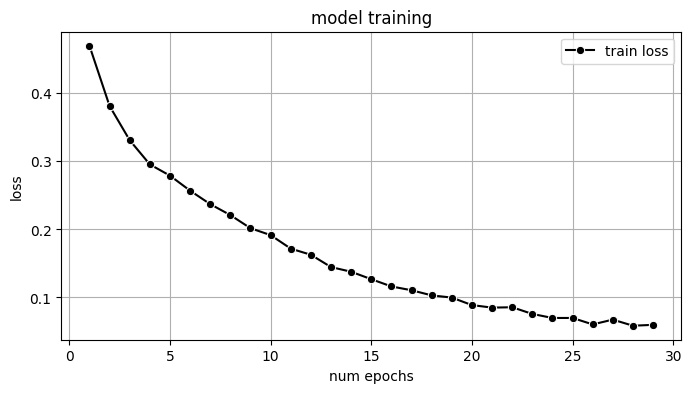

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.lineplot(x=range(1, 30), y=loss_arr, marker='o', color='k', label='train loss')
ax.set(xlabel='num epochs', ylabel='loss', title='model training')
ax.legend()
ax.grid(True)
plt.show()

In [ ]:
"""
Подготовка валидационных данных
"""

edge_label_index = val_data["user", "rates", "movie"].edge_label_index
edge_label = val_data["user", "rates", "movie"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

Sampled mini-batch:
HeteroData(
  user={
    node_id=[2850],
    n_id=[2850],
    num_sampled_nodes=[3],
  },
  movie={
    node_id=[414],
    x=[414, 105],
    n_id=[414],
    num_sampled_nodes=[3],
  },
  (user, rates, movie)={
    edge_index=[2, 2512],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[2512],
    num_sampled_edges=[2],
    input_id=[384],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 2633],
    e_id=[2633],
    num_sampled_edges=[2],
  }
)


In [ ]:
"""
Оценка точности работы модели
"""

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")

100%|██████████| 23/23 [00:00<00:00, 92.55it/s]


Validation AUC: 0.9070


**Выводы:**

1. Данные значений функции потерь по эпохам обучения показывают, что потери снижаются с ростом числа пройденных эпох, что свидетельствует о корректности модели и правильной предобработке данных.
2. Модель обладает высокой прогнозтической способностью, о чём свидетельствует высокое значение метрики roc-auc на валидационных данных.

.

**Дополнительный комментарий:**

1. Далеко не сразу получилось правильно подготовить данные данного набора для передачи их модели и после этого понять, почему при обучении возникают ошибки.
2. Поэтому предпринимались попытки решить поставленную задачу на других датасетах с сайта https://pytorch-geometric.readthedocs.io/en/2.6.0/modules/datasets.html#heterogeneous-datasets
3. Там также возникли свои проблемы.
4. Например, датасет Taobao не помещался в память колаба при его загрузке.
5. А вершины графа LastFM не имели атрибута "точка икс", что просто повергло в шок, пока не стало понятно что это такое, и что такие данные можно добавлять в набор самостоятельно и корректировать их (при необходимости).
6. В общем, было интересно

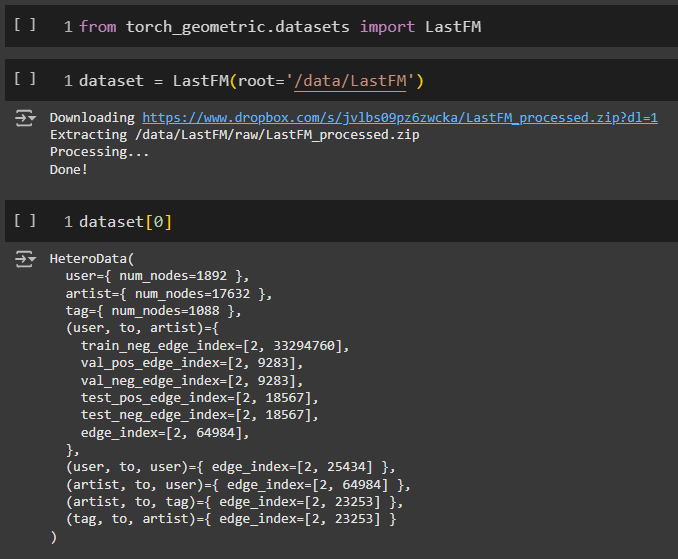